# Data Preprocessing and Exploratory Data Analysis

In this notebook, i detail my thought process as i work through the data preprocessing while also drawing insights from the visualisations during exploratory data analysis.

The preprocessing and EDA will be performed on the training data, and the respective preprocessing / transformations will be made to the testing data set at the end.

Below is a table of contents to aid navigation to specific sections of the notebook.

__Note__: Majority of the functions used in this notebook are called from the `cleaning.py` and `visualisation.py` scripts in the `utils` folder.

## Table of Contents <a id='table_contents'></a>

#### [1. Basic Data Preprocessing](#preprocessing)
* [Initial Analysis of our Data](#initial_analysis)
* [Correcting Data Types](#data_types)
* [Handling Missing Data](#missing_data)

### Importing Libraries

In [1]:
# Standard Tools
from scipy import stats
import pandas as pd
import numpy as np
import pickle

# Visualisation Tools
import matplotlib.pyplot as plt
import seaborn as sns

# Custom Functions
from utils import visualisation as viz
from utils import cleaning

# Misc
import warnings
warnings.filterwarnings('ignore')

# Pandas Options
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Plotting Options
plt.rcParams['axes.facecolor'] = 'white'
plt.style.use('seaborn-muted')

# Magic Functions
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Basic Data Preprocessing <a id='preprocessing'></a>

In this section, we want to take a preliminary look at our data. This allows us to __identify potential errors__ within our data such as __missing values, incorrect data entry / data types and skewed features__, in order to rectify them.  

### Loading Data and Initial Analysis <a id='initial_analysis'></a>

In [2]:
train = pd.read_csv('./data/train.csv')

In [3]:
train.head()

,id,industry,state,request_date,term,employee_count,business_new,business_type,location,other_loans,loan_amount,insured_amount,default_status
0,4050975007,Others,VA,27-Apr-10,34,4,New,0,Rural,N,"$35,000.00","$35,000.00",1
1,3735095001,Manufacturing,CA,05-Nov-09,107,1,New,0,Rural,N,"$15,000.00","$13,500.00",1
2,3936555004,Trading,CA,26-Feb-10,84,1,New,0,Rural,Y,"$265,000.00","$100,000.00",0
3,4130405000,Engineering,MI,10-Jun-10,240,21,New,0,Rural,N,"$255,000.00","$255,000.00",0
4,4263615008,Education,NH,23-Sep-10,36,1,Existing,0,Rural,N,"$13,300.00","$6,650.00",0


In [4]:
# summary report that does basic cleaning and identifies common issues such as missing data or skewed features
train = cleaning.data_report(train, reminders=True)

SUMMARY REPORT FOR DATASET

Cleaning dataframe columns ...
Removing whitespaces ...
Replacing dashes with underscores ...
Changing to lower case ...
Dataframe column headers have been formatted.

The data has 2402 observations and 13 features.
Numerical Features : 5
Categorical Features : 8

The data has missing values.
- To save the features and their respective missing values, call the variable_missing_percentage function.

Methods to handle missing values for Numerical Features:
1. Impute missing values with Mean / Median / KNN Imputer
2. Drop feature with high proportion of missing values.
3. For time series data, consider Linear Interpolation / Back-filling / Forward-filling

Methods to handle missing values for Categorical Features:
1. Impute missing values with Mode / KNN Imputer
2. Classify all the missing values as a new category.
3. Drop feature with high proportion of missing values.

There are Numerical Features within the data that have skewness greater than 1 in magnitude

In [5]:
# dropping the 'id' feature as we can use the Dataframe's index
train = train.drop('id', axis=1)

### Checking Feature Data Types <a id='data_types'></a>

From the above summary report on our training dataset, we see that we have a few issues such as missing data and skewed variables. 

But before we handle those issues, we need to check if the features have the correct data types. 

In [6]:
# checking data types
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2402 entries, 0 to 2401
Data columns (total 12 columns):
industry          2401 non-null object
state             2402 non-null object
request_date      2402 non-null object
term              2402 non-null int64
employee_count    2402 non-null int64
business_new      2402 non-null object
business_type     2402 non-null int64
location          2402 non-null object
other_loans       2402 non-null object
loan_amount       2402 non-null object
insured_amount    2402 non-null object
default_status    2402 non-null int64
dtypes: int64(4), object(8)
memory usage: 150.2+ KB


There two features `loan_amount` and `insured_amount`  have __incorrect data types__, as they have 'objects' data type when they are in fact numerical data.

From our initial look at the data, we  know that the __problem is due to the '$' character__ being included in the values.

In [7]:
# removing '$' and correcting data types
train['loan_amount'] = train['loan_amount'].replace('[\$,]', '', regex=True).astype(float)
train['insured_amount'] = train['insured_amount'].replace('[\$,]', '', regex=True).astype(float)

Furthermore, we will convert the `request_date` feature  to a __datetime object__ as it allows us to __extract the time features__ such as the __month__ and __year__ of the request date.

We will also be dropping the `request_date` feature after extracting the time features as we __do not need the level of granularity of having individual dates__. One hot encoding the feature would result in a __sparse matrix__ as well.

In [8]:
# converting to datetime format
train['request_date'] = pd.to_datetime(train['request_date'], format='%d-%b-%y')

In [9]:
# creating new features for the year and month that the loan was requested and dropping original feature
train = cleaning.create_time_vars(train, time_var='request_date', year=True, month=True,
                                  day=False, season=False, drop=True)

Original time variable has been dropped.


Additionally our numerical features are expected to be postive, therefore we need to chekc if there are any negative values which may signal some error during the data collection stage.

In [10]:
# checking for negative values
negative_values = cleaning.check_negative(train)
negative_values

There are no numeric variables with negative values.


,NegativeValues
term,False
employee_count,False
business_type,False
loan_amount,False
insured_amount,False
default_status,False


### Handling Missing Data <a id='missing_data'></a>

Now that we have ensured the data types are correct and have sanity checked our data, we can move on to handling missing data.

In [11]:
# displays features with missing data and proportion of data that is missing
cleaning.variable_missing_percentage(train)

The dataframe has 13 variables.
There are a total of 1 variables with missing values and their missing percentages are as follows:

industry    0.04


There is only one feature with missing values. As the __percentage missing is small__, we will just __remove the data points__.

In [12]:
train = train.dropna(how='any')
cleaning.variable_missing_percentage(train)

The dataframe has 13 variables.
The dataframe has no missing values in any column.


Now that we have sanitised our data sufficiently, we can move on to analysing our features individually.

[Return to Table of Contents](#table_contents)

## Exploratory Data Analysis <a id='eda'></a>

In this section, we will be using visualisations to help understand our features individually and how they relate to the default rate. 

### Target Feature : Default Status <a id='target'></a>

The aim of this project is to predict which companies will default on their loan based on their respective features.

Therefore, we first need to understand the distribution of our target feature, `default_status`.

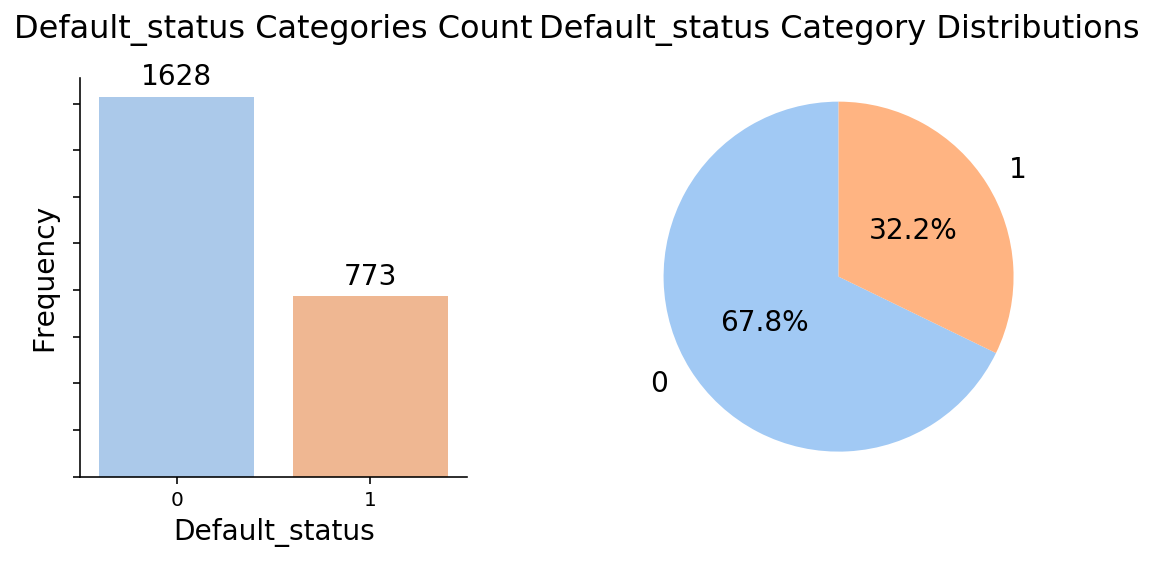

In [13]:
viz.count_pie_plots(train, 'default_status', tight_layout=True)

The figure shows that we are dealing with an __imbalanced dataset__, with more companies repaying their loans than defaulting.

The __average default rate of all loans is around 32%__, which is considerably high.

### Continuous Features Analysis <a id='cont_features'></a>

In this section, we will be taking a closer look at the __distributions__ of our continuous features. We will also model the __interactions__ between some features.

Previously, we have noted that __some features have skewed distributions__. Alleviating skew usually helps to improve model fitting later on, therefore we will __apply appropriate transformations__ and check if it alleviates the issue.  

In [14]:
continuous_features = ['term', 'employee_count', 'loan_amount', 'insured_amount']

# summary statistics for these features
train[continuous_features].describe().round(1)

,term,employee_count,loan_amount,insured_amount
count,2401.0,2401.0,2401.0,2401.0
mean,87.6,9.3,204572.8,155050.0
std,62.7,21.2,364387.6,311483.3
min,1.0,0.0,3000.0,1700.0
25%,52.0,2.0,25000.0,12750.0
50%,84.0,4.0,50000.0,35000.0
75%,95.0,9.0,216990.0,125000.0
max,312.0,500.0,4000000.0,4000000.0


In [15]:
skewed_features = cleaning.check_skewness(train[continuous_features])

The following 4 variables are highly skewed:

employee_count    9.76
insured_amount    3.62
loan_amount       3.40
term              1.98


It appears that all our continuous features are highly skewed, given the __high standard deviation__ in reation to the mean as well as the max value having a large difference from the 75th percentile.

Next, we proceed to visualising their distributions and applying the appropriate transformations.

### Feature : Loan Term

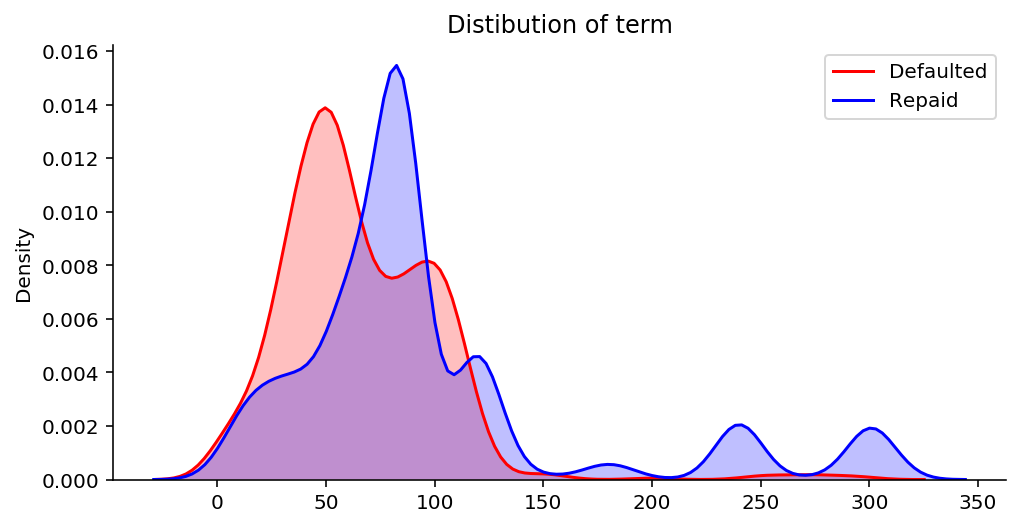

In [16]:
viz.kdeplot_binary(train, 'term', 'default_status', figsize=(8,4), pos_label='Defaulted', neg_label='Repaid')

From the figure above, it seems that loans with __shorter terms__ tend to have a __higher rate of default__. 

For interpretation purposes, we will bin the term feature by year. Aside from 15, 20 and 25 year term lengths, terms that are longer than 10 years will be binned together.

In [17]:
train['term_duration'] = train.term.apply(lambda x: int(np.ceil(x/12)))
train['term_duration'] = train.term_duration.apply(lambda x:
                                                   str(x)+'_year' if x <= 10
                                                   else str(x)+'_year' if x == 15
                                                   else str(x)+'_year' if x == 20
                                                   else str(x)+'_year' if x == 25
                                                   else 'Other_term_length')

term_duration_order = [str(i) + '_year' for i in range(1,11)]
term_duration_order += ['15_year', '20_year', '25_year', 'Other_term_length']

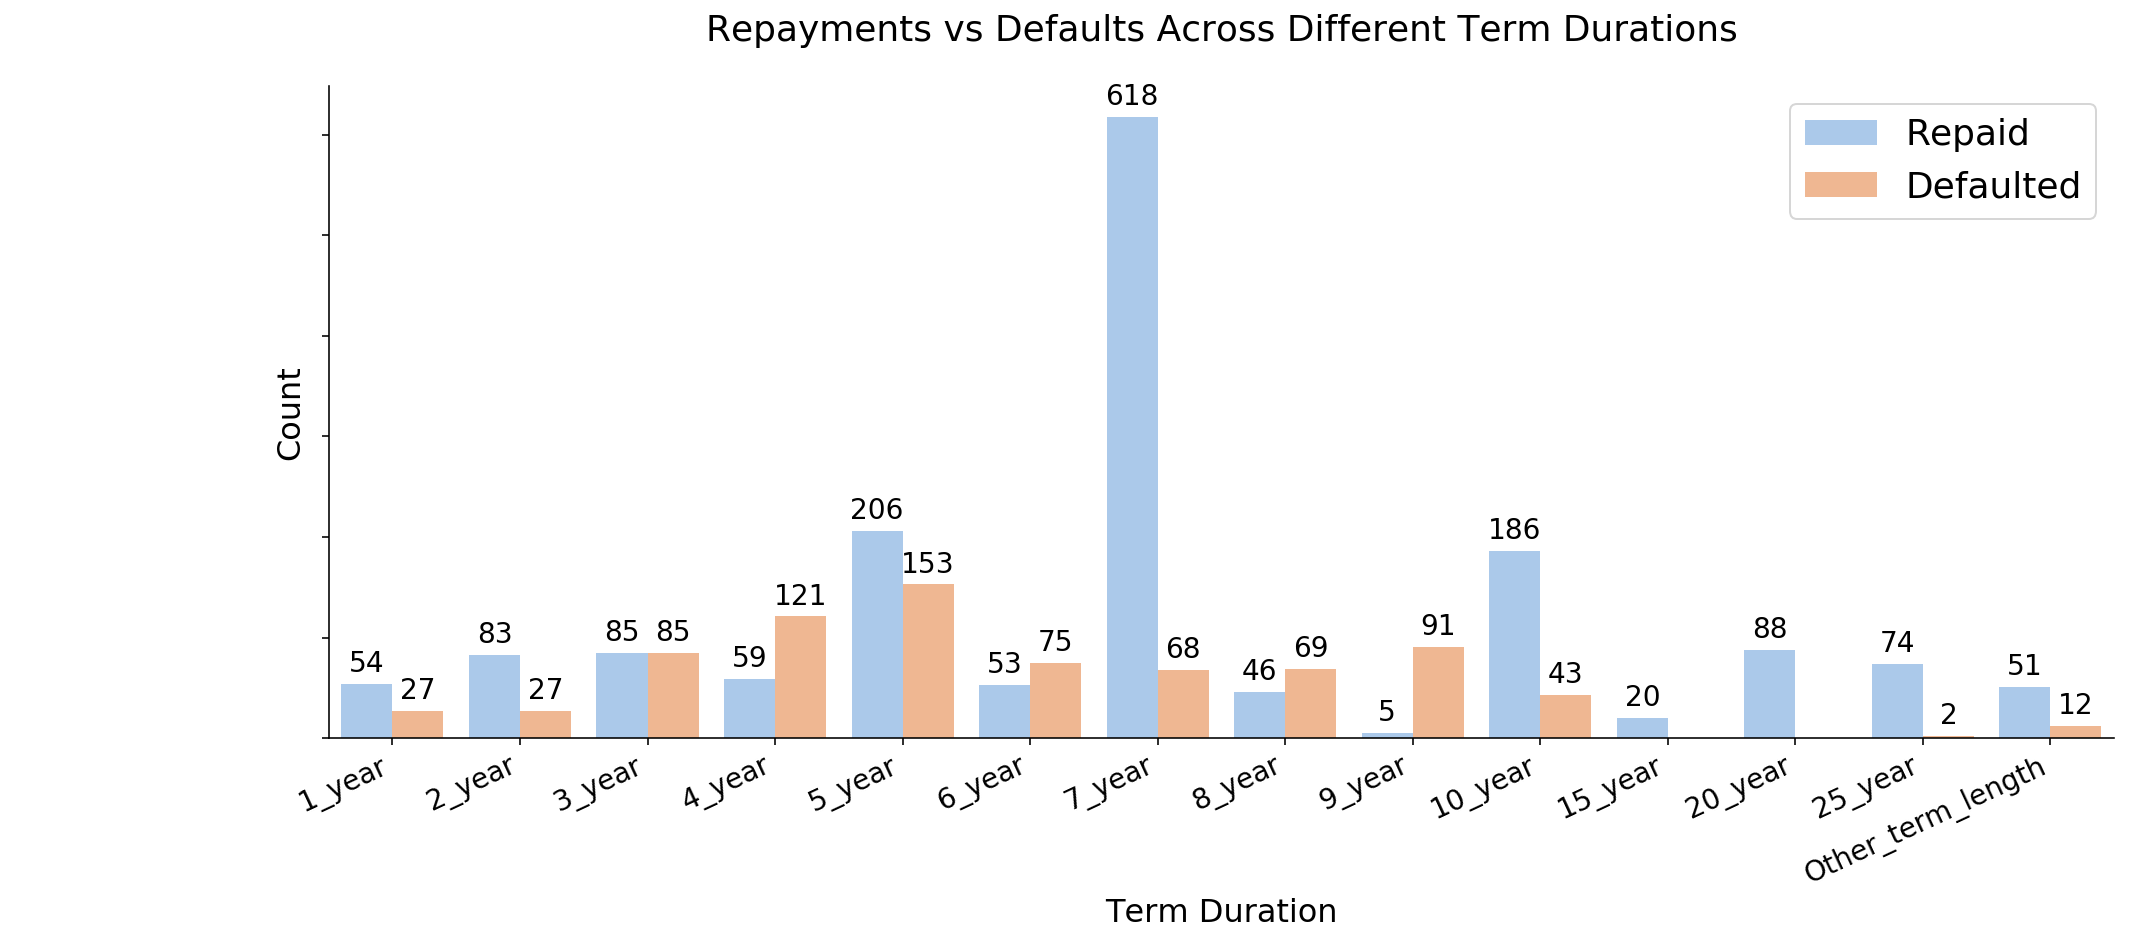

In [21]:
plt.figure(figsize=(16,6))
plt.title('Repayments vs Defaults Across Different Term Durations', size=18, y=1.05)
ax = sns.countplot(x='term_duration', hue='default_status', data=train, order=term_duration_order, palette='pastel')
plt.legend(labels=['Repaid', 'Defaulted'], loc='upper right', prop={'size' : 18})
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, horizontalalignment='right', size=14)
ax.set_yticklabels([])
ax.set_xlabel('Term Duration', size=16)
ax.set_ylabel('Count', size=16)
viz.annotate_plot(ax, dec_places=0, annot_size=14)
sns.despine();

From the figure above, we notice that the __safest loan terms__ are those with either __short durations of 1-2 years__, or very __long durations of more than 10 years__.

Loan terms between 3 and 9 years inclusive are the most risky loans. Aside from loan terms of 5 and 7 years, the other term durations all had more defaults than repayments.

#### Median Loan Amount across Term Durations

Now that we know which loan terms have the highest default rates, we want to investigate what is the difference between the median loan amount for repaid and defaulted loans.

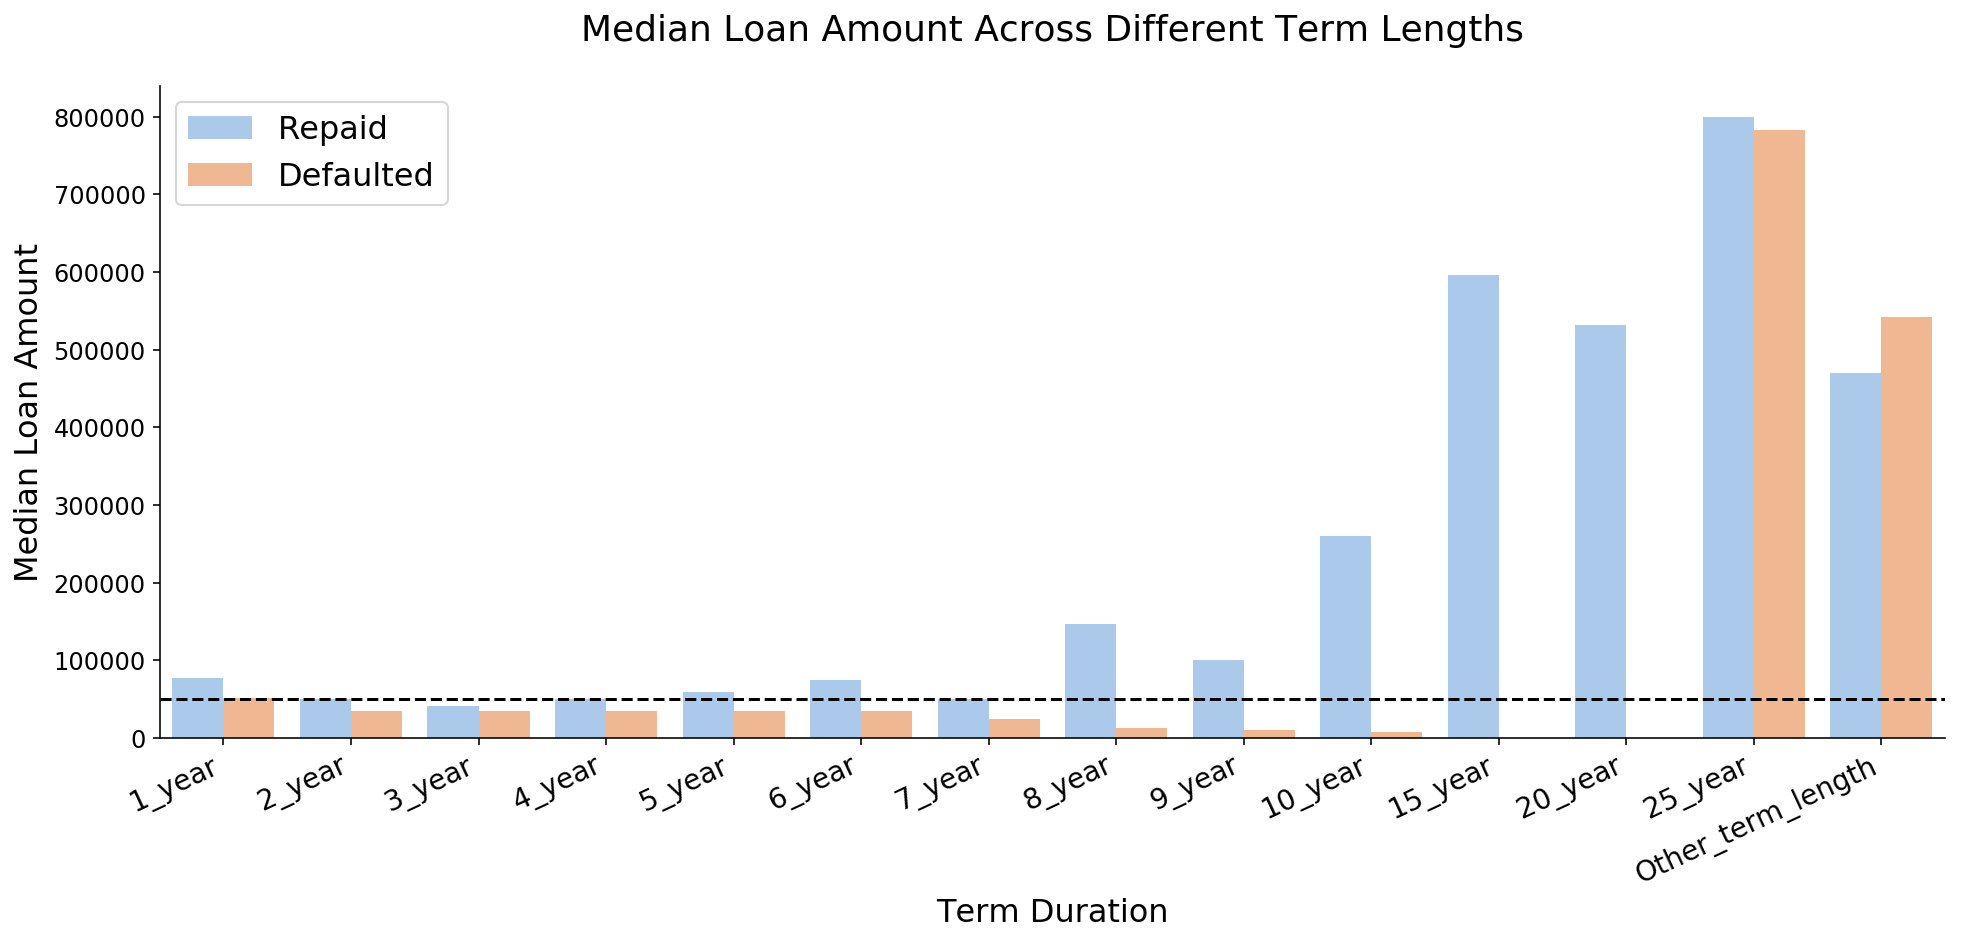

In [41]:
avg_loan_groupby_term = train.groupby(['term_duration', 'default_status']).agg({'loan_amount' : 'median'}).reset_index()

plt.figure(figsize=(16,6))
plt.title('Median Loan Amount Across Different Term Lengths', size=18, y=1.05)
ax = sns.barplot(x='term_duration', y='loan_amount', hue='default_status', data=avg_loan_groupby_term,
                 order=term_duration_order, palette='pastel')
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, horizontalalignment='right', size=14)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ['Repaid', 'Defaulted'], loc='upper left', prop={'size':16})
ax.set_xlabel('Term Duration', size=16)
ax.set_ylabel('Median Loan Amount', size=16)
ax.set_yticks(np.arange(0,900000, step=100000))
ax.set_yticklabels(np.arange(0,900000, step=100000), size=12)
ax.axhline(50000, ls='--',color='black')
sns.despine()
plt.show();

From the figure above, we observe that for all term durations, the median loan amount for repaid loans are greater than that of defaulted loans.

Moreover, most defaulted loans for term duration of less than 10 years have a median loan value lower than $100000.

To get a better view of our data, we will visualise the loans that have terms with less than 10 years.

In [42]:
short_term_durations = term_duration_order[:-5]
avg_loan_groupby_term = avg_loan_groupby_term.loc[avg_loan_groupby_term.term_duration.isin(short_term_durations)]

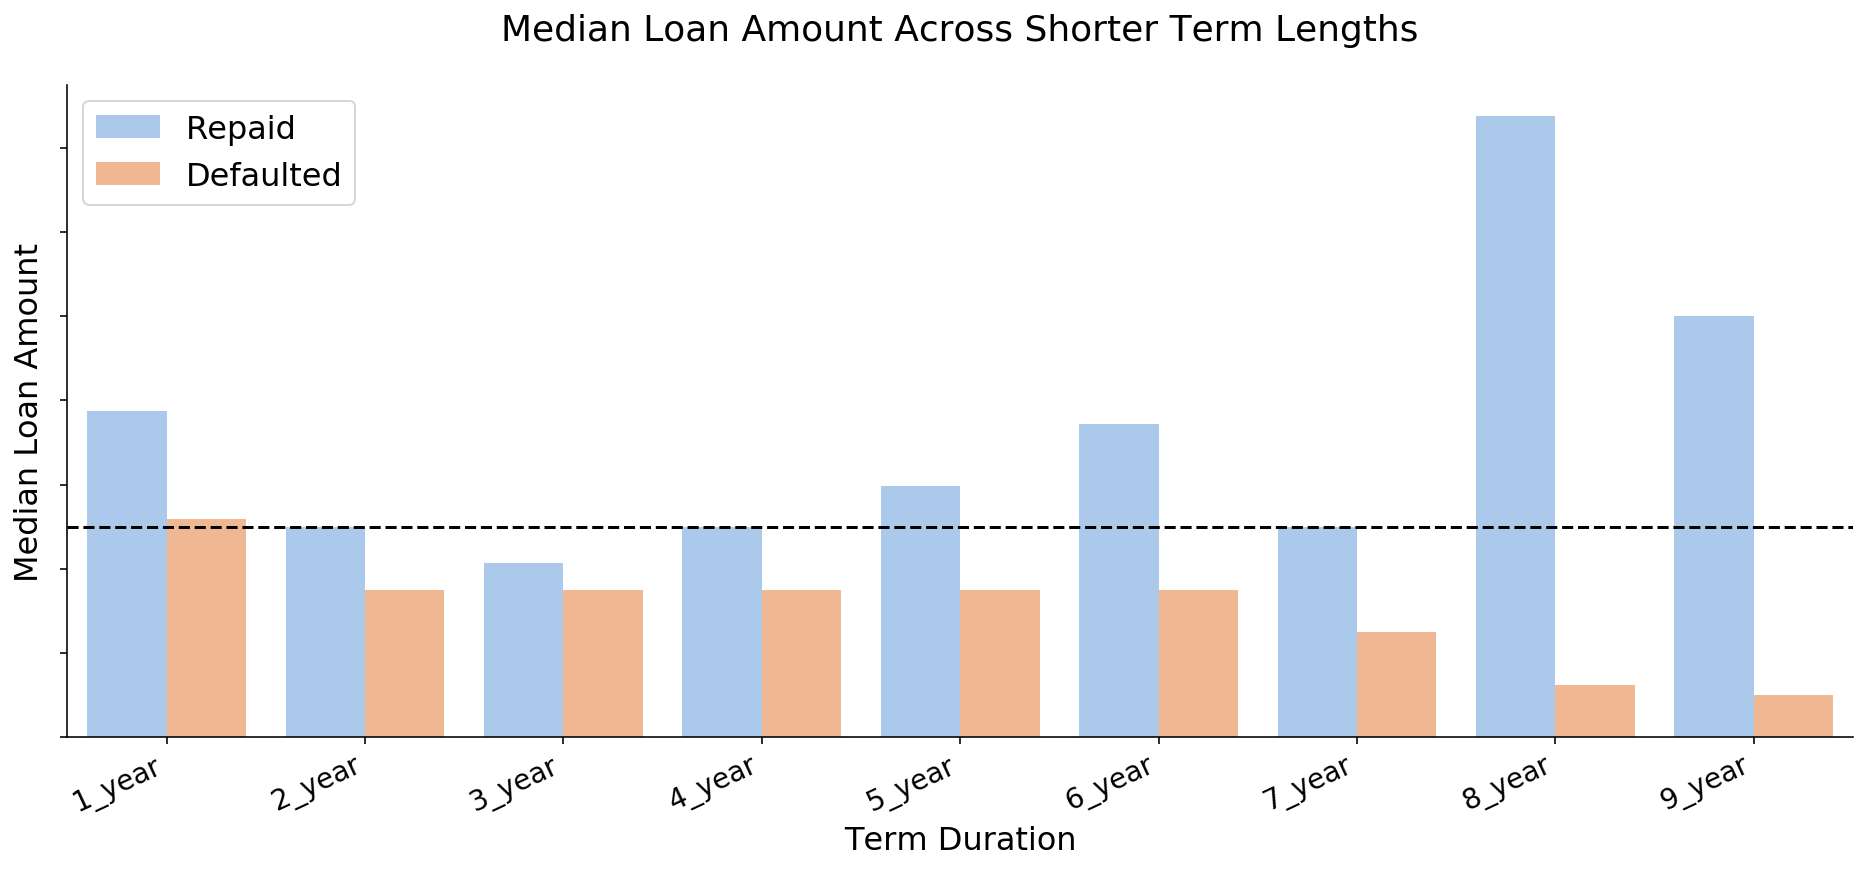

In [44]:
plt.figure(figsize=(16,6))
plt.title('Median Loan Amount Across Shorter Term Lengths', size=18, y=1.05)
ax = sns.barplot(x='term_duration',y='loan_amount', hue='default_status', data=avg_loan_groupby_term,
                 order=short_term_durations, palette='pastel')
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, horizontalalignment='right', size=14)
ax.set_yticklabels(ax.get_yticklabels(), size=12)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ['Repaid', 'Defaulted'], loc='upper left', prop={'size': 16})
ax.set_xlabel('Term Duration', size=16)
ax.set_ylabel('Median Loan Amount', size=16)
ax.axhline(50000, ls='--', color='black')
sns.despine();

From the figure above, it appears that the median loan amount for defaulted loans decreases as term duration increases. Therefore, the company may want to be wary of small loan amounts of less than $50,000 with long term durations.

In [45]:
# dropping term_duration as we finished our analysis
train = train.drop('term_duration', axis=1)